In [1]:
# filter out annoying warnings
import warnings
warnings.filterwarnings('ignore', category=UserWarning)
warnings.filterwarnings('ignore', category=DeprecationWarning)

In [2]:
%matplotlib inline
import MDAnalysis as MDA

In [3]:
print MDA.__version__

0.15.1-dev0


In [4]:
from bokeh.plotting import figure, show
from bokeh.io import output_notebook
from bokeh.models import HoverTool, BoxSelectTool


In [5]:
import matplotlib.pyplot as plt
import os
import numpy as np
import MDAnalysis.analysis.diffusionmap as diffusionmap
import MDAnalysis.analysis.rms as rms
MDA.start_logging()

MDAnalysis  : INFO     MDAnalysis 0.15.1-dev0 STARTED logging to 'MDAnalysis.log'


In [6]:
# nicer then the default plotting style
plt.style.use('ggplot')

In [7]:
print os.getcwd()

/home/jdetlefs/github/dimension_reduction/diffusionMaps


*Be sure to install the adk simulation from [this link](http://becksteinlab.github.io/MDAnalysis-workshop/datadownload.html)*

These are commands you need to input in the terminal in mac or linux to download and unzip:

```
curl -o mdatrj.zip -L 'https://www.dropbox.com/sh/am6y00kac8myihe/AABDiQI28fWnRZueQTT7W2s1a?dl=1'
unzip mdatrj.zip && rm mdatrj.zip
```


In [8]:
u = MDA.Universe('./equilibrium/adk4AKE.psf','./equilibrium/1ake_007-nowater-core-dt240ps.dcd')
print u.trajectory

<DCDReader ./equilibrium/1ake_007-nowater-core-dt240ps.dcd with 4187 frames of 3341 atoms>


In [9]:
dist_step20 = diffusionmap.DistanceMatrix(u, select='backbone', step=20)
%time dist_step20.run()

MDAnalysis.analysis.base: INFO     Starting preparation
MDAnalysis.analysis.base: INFO     Finishing up


CPU times: user 3.27 s, sys: 336 ms, total: 3.6 s
Wall time: 3.62 s


In [10]:
dist_step10 = diffusionmap.DistanceMatrix(u, select='backbone', step=10)
%time dist_step10.run()

MDAnalysis.analysis.base: INFO     Starting preparation
MDAnalysis.analysis.base: INFO     Finishing up


CPU times: user 13.1 s, sys: 1.32 s, total: 14.4 s
Wall time: 14.4 s


In [11]:
dist_step5 = diffusionmap.DistanceMatrix(u, select='backbone', step=5)
%time dist_step5.run()

MDAnalysis.analysis.base: INFO     Starting preparation
MDAnalysis.analysis.base: INFO     Finishing up


CPU times: user 52 s, sys: 5.58 s, total: 57.6 s
Wall time: 57.6 s


In [12]:
dist_step3 = diffusionmap.DistanceMatrix(u, select='backbone', step=3)
%time dist_step3.run()

MDAnalysis.analysis.base: INFO     Starting preparation
MDAnalysis.analysis.base: INFO     Finishing up


CPU times: user 2min 23s, sys: 15.1 s, total: 2min 38s
Wall time: 2min 38s


In [13]:
dist_step2= diffusionmap.DistanceMatrix(u, select='backbone', step=2)
%time dist_step2.run()

MDAnalysis.analysis.base: INFO     Starting preparation
MDAnalysis.analysis.base: INFO     Finishing up


CPU times: user 5min 13s, sys: 32.5 s, total: 5min 45s
Wall time: 5min 45s


# Lets do some diffusion maps
Now that weve figured out timings,
lets 
+ investigate the distance_matrix
+ pick a reasonable constant epsilon 
+ find the spectrum of reasonable eigenvalues
+ perform an embedding
+ plot the first two coordinates of the embedding

In [14]:
print dist_step2.dist_matrix
print dist_step2.nframes

[[ 0.          1.10143562  1.89894914 ...,  6.56860701  7.03562688
   6.56492418]
 [ 1.10143562  0.          1.29750747 ...,  6.41152261  6.96453771
   6.43888864]
 [ 1.89894914  1.29750747  0.         ...,  6.1914791   6.83702618
   6.22915649]
 ..., 
 [ 6.56860701  6.41152261  6.1914791  ...,  0.          1.52419324
   1.29568115]
 [ 7.03562688  6.96453771  6.83702618 ...,  1.52419324  0.          1.30615125]
 [ 6.56492418  6.43888864  6.22915649 ...,  1.29568115  1.30615125  0.        ]]
2094


A reasonable value of epsilon corresponds to two elements that are close on a free energy landscape, so lets set epsilon to 1.101 one of our smaller rmsd jumps between frames. Before doing this, let's save the distance matrix, because after determining the epsilon, it will be permanently altered for memory savings.

In [15]:
dist_step2.save('dist')

MDAnalysis.analysis.diffusionmap: INFO     Wrote the distance-squared matrix to file 'dist'


In [16]:
epsilon = diffusionmap.EpsilonConstant(dist_step2,1.101)

In [17]:
epsilon.determine_epsilon()
print epsilon.scaledMatrix

[[ 0.          1.00039566  1.72474945 ...,  5.96603724  6.39021515
   5.96269226]
 [ 1.00039566  0.          1.1784809  ...,  5.82336295  6.32564733
   5.84821857]
 [ 1.72474945  1.1784809   0.         ...,  5.62350509  6.20983304
   5.65772615]
 ..., 
 [ 5.96603724  5.82336295  5.62350509 ...,  0.          1.3843717
   1.17682212]
 [ 6.39021515  6.32564733  6.20983304 ...,  1.3843717   0.          1.18633174]
 [ 5.96269226  5.84821857  5.65772615 ...,  1.17682212  1.18633174  0.        ]]


Oh no! I executed it twice, this is probably a design flaw and something I should fix. For now I am just going to reload the old dist matrix and do it again.

In [18]:
dist_step2.dist_matrix = np.load('dist.npy')
epsilon = diffusionmap.EpsilonConstant(dist_step2,1.101)

In [19]:
print dist_step2.dist_matrix

[[ 0.          1.10143562  1.89894914 ...,  6.56860701  7.03562688
   6.56492418]
 [ 1.10143562  0.          1.29750747 ...,  6.41152261  6.96453771
   6.43888864]
 [ 1.89894914  1.29750747  0.         ...,  6.1914791   6.83702618
   6.22915649]
 ..., 
 [ 6.56860701  6.41152261  6.1914791  ...,  0.          1.52419324
   1.29568115]
 [ 7.03562688  6.96453771  6.83702618 ...,  1.52419324  0.          1.30615125]
 [ 6.56492418  6.43888864  6.22915649 ...,  1.29568115  1.30615125  0.        ]]


Back to normal!

In [20]:
epsilon.determine_epsilon()

In [21]:
dmap = diffusionmap.DiffusionMap(dist_step2, epsilon)
dmap.decompose_kernel()

In [22]:
print dmap._kernel

[[  4.08275488e-01   1.32783486e-01   5.99079107e-02 ...,   9.61301785e-05
    8.05778040e-05   1.16357462e-04]
 [  1.32783486e-01   3.19350392e-01   9.14919036e-02 ...,   9.80571986e-05
    7.60175639e-05   1.15389584e-04]
 [  5.99079107e-02   9.14919036e-02   2.76766408e-01 ...,   1.11480680e-04
    7.94574120e-05   1.29962894e-04]
 ..., 
 [  9.61301785e-05   9.80571986e-05   1.11480680e-04 ...,   3.44191625e-03
    1.10445776e-03   1.27995508e-03]
 [  8.05778040e-05   7.60175639e-05   7.94574120e-05 ...,   1.10445776e-03
    5.64869210e-03   1.62419644e-03]
 [  1.16357462e-04   1.15389584e-04   1.29962894e-04 ...,   1.27995508e-03
    1.62419644e-03   5.00914801e-03]]


In [23]:
print dmap.eigenvalues[0:20]

[ 1.          0.69277374  0.52030148  0.50039118  0.43120723  0.30717034
  0.27423425  0.23169618  0.20927607  0.20038442  0.18602528  0.17478776
  0.17224001  0.16057827  0.15626107  0.14670551  0.13853813  0.12431708
  0.12022056  0.11162649]


In [24]:
fit = dmap.transform(2)
print fit
print fit.shape[0]

MDAnalysis.analysis.base: INFO     Starting preparation
MDAnalysis.analysis.base: INFO     Finishing up


[[  1.56516643e-02   1.60775533e-02]
 [  5.17402048e-01   4.81984790e-01]
 [  3.26236126e-02   2.38964568e-02]
 ..., 
 [  5.94913872e-07   9.37762586e-07]
 [ -7.20617868e-08  -2.72614271e-07]
 [  2.40392845e-10  -8.62542791e-07]]
2094


/home/jdetlefs/.virtualenvs/MDA/local/lib/python2.7/site-packages/IPython/core/formatters.py:92: DeprecationWarning: DisplayFormatter._ipython_display_formatter_default is deprecated: use @default decorator instead.
  def _ipython_display_formatter_default(self):
/home/jdetlefs/.virtualenvs/MDA/local/lib/python2.7/site-packages/IPython/core/formatters.py:669: DeprecationWarning: PlainTextFormatter._singleton_printers_default is deprecated: use @default decorator instead.
  def _singleton_printers_default(self):


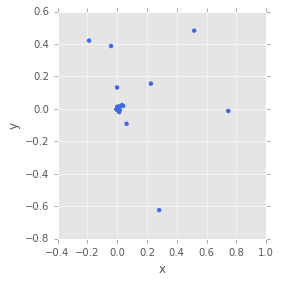

In [25]:
# Matplotlib figure
f, ax = plt.subplots(figsize=plt.figaspect(1))

x = fit[:,0]
y = fit[:,1]
ax.scatter(x, y, edgecolor='none', color='royalblue')
ax.set(xlabel='x', ylabel='y')

plt.tight_layout()
plt.savefig('diffusion_map.svg', dpi=300)

In [41]:
output_notebook()

Loading BokehJS ...

In [42]:
TOOLS = [BoxSelectTool(), HoverTool()]


In [43]:
p = figure(tools=TOOLS)

p.circle(x,y, fill_alpha=.6)


As you can see, the points far away in terms of diffusion distance occur only in the beginning! So it looks like right now diffusion mapping only captures the initial closing, but not the opening. (Right now bokeh has an issue with too many hits with the hover tool.)

In [44]:
show(p)